In [21]:
import time
from itertools import product

import matplotlib.pyplot as plt
import mlrose_hiive
import pandas as pd
import seaborn as sns
from sklearn.metrics import (ConfusionMatrixDisplay, classification_report,
                             confusion_matrix, f1_score)
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from transform_data import get_train_test_ds

random_state = 42
cv = 3
mlp_layers = [64, 16]

In [8]:
X, X_train, X_test, y, y_train, y_test = get_train_test_ds('income', 'data/adult.data', random_state)
X_train

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,male,education_10th,education_11th,education_12th,...,relationship_Own-child,relationship_Unmarried,relationship_Wife,race_Amer-Indian-Eskimo,race_Asian-Pac-Islander,race_Black,race_Other,race_White,sex_Female,sex_Male
0,32,37210,13,0,0,45,1,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
1,43,101950,14,0,0,45,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
2,20,122244,9,0,0,28,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
3,40,24763,10,6849,0,40,1,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
4,24,113936,13,0,0,40,1,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26043,35,179171,9,0,0,38,0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
26044,39,421633,10,0,0,30,0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
26045,55,82098,9,0,0,55,1,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
26046,26,50053,13,0,0,55,1,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


In [15]:
clf = mlrose_hiive.NeuralNetwork(
  hidden_nodes=mlp_layers, 
  activation ='relu', 
  algorithm ='random_hill_climb', 
  max_iters=1000, 
  bias=True, 
  is_classifier=True, 
  early_stopping=True, 
  max_attempts=100, 
  random_state=random_state, 
  curve=True,
)
pipe = Pipeline([
  ('scaler', StandardScaler()), 
  ('rhc', clf),
])

In [4]:
# CV search
param_grid = {
    'rhc__learning_rate': [0.0001, 0.01, 0.1, 1],
    'rhc__restarts': [2, 4, 8],
}

best_score = None
best_params = None
df_cols = list(param_grid.keys()) + ['score']
metrics_dict = {
    k: [] for k in df_cols
}

param_combinations = product(*param_grid.values())
for params in param_combinations:
    try_param = dict(zip(param_grid.keys(), params))
    print(try_param)
    pipe.set_params(**try_param)
    
    # Perform cross-validation
    kf = KFold(n_splits=cv)
    k = 0
    scores = []
    for train_index, valid_index in kf.split(X_train):
        start = time.time()
        k += 1
        X_split_train, X_valid = X_train.loc[train_index], X_train.loc[valid_index]
        y_split_train, y_valid = y_train.loc[train_index], y_train.loc[valid_index]
        pipe.fit(X_split_train, y_split_train)
        y_pred = pipe.predict(X_valid)
        score = f1_score(y_valid, y_pred)
        scores.append(score)
        end = time.time()
        run_time = end - start
        print(f"k{k} run time: {run_time}s")
    
    # Calculate mean score across all folds
    mean_score = sum(scores) / len(scores)
    for k, v in try_param.items():
        metrics_dict[k].append(v)
    metrics_dict['score'].append(mean_score)
metrics_df = pd.DataFrame(metrics_dict)
metrics_df

{'rhc__learning_rate': 0.0001, 'rhc__restarts': 2}
k1 run time: 149.69157481193542s
k2 run time: 145.63216972351074s
k3 run time: 143.24322748184204s
{'rhc__learning_rate': 0.0001, 'rhc__restarts': 4}
k1 run time: 238.1244068145752s
k2 run time: 236.0238597393036s
k3 run time: 236.39466381072998s
{'rhc__learning_rate': 0.0001, 'rhc__restarts': 8}
k1 run time: 433.53840494155884s
k2 run time: 435.1030514240265s
k3 run time: 437.60351181030273s
{'rhc__learning_rate': 0.01, 'rhc__restarts': 2}
k1 run time: 145.96259307861328s
k2 run time: 145.63220119476318s
k3 run time: 144.03794765472412s
{'rhc__learning_rate': 0.01, 'rhc__restarts': 4}
k1 run time: 237.2271556854248s
k2 run time: 239.69333720207214s
k3 run time: 239.05754685401917s
{'rhc__learning_rate': 0.01, 'rhc__restarts': 8}
k1 run time: 432.65369176864624s
k2 run time: 432.7389006614685s
k3 run time: 425.1707124710083s
{'rhc__learning_rate': 0.1, 'rhc__restarts': 2}
k1 run time: 144.544451713562s
k2 run time: 144.0110330581665s
k

,rhc__learning_rate,rhc__restarts,score
0,0.0001,2,0.225039
1,0.0001,4,0.291459
2,0.0001,8,0.291459
3,0.0100,2,0.227028
4,0.0100,4,0.293811
5,0.0100,8,0.293811
6,0.1000,2,0.259264
7,0.1000,4,0.316238
8,0.1000,8,0.316238
9,1.0000,2,0.561469


In [5]:
metrics_df.to_parquet("./metrics/rhc_metrics.parquet")

In [10]:
metrics_df = pd.read_parquet("./metrics/rhc_metrics.parquet")

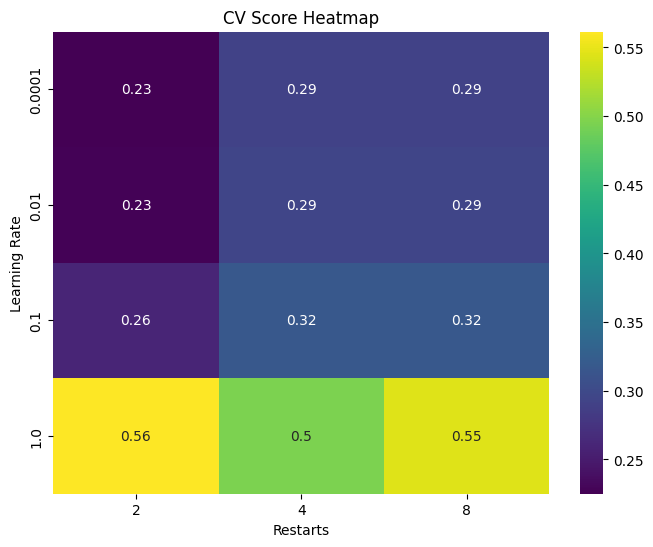

In [11]:
heatmap_data = metrics_df.pivot(index='rhc__learning_rate', columns='rhc__restarts', values='score')
plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_data, annot=True, cmap='viridis')

# Set labels and title
plt.xlabel('Restarts')
plt.ylabel('Learning Rate')
plt.title('CV Score Heatmap')

plt.show()

In [12]:
params_key = [x for x in metrics_df.columns.to_list() if x != 'score']
best_params = metrics_df.sort_values(['score'], ascending=False)[params_key].iloc[0].to_dict()
for k in params_key:
    if best_params[k] % 1 != 0:
        continue
    best_params[k] = int(best_params.pop(k))
best_params

{'rhc__learning_rate': 1, 'rhc__restarts': 2}

In [16]:
# train model on full dataset
pipe.set_params(**best_params)
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)

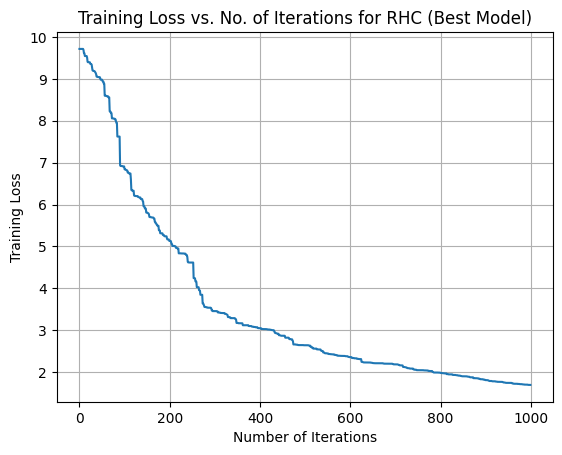

In [17]:
plt.figure()
plt.plot(pipe['rhc'].fitness_curve[:, 0])
plt.grid()
plt.xlabel('Number of Iterations')
plt.ylabel('Training Loss')
plt.title('Training Loss vs. No. of Iterations for RHC (Best Model)')
plt.show()

In [18]:
classification_report(y_test, y_pred, output_dict=True)

{'0': {'precision': 0.8622356495468277,
  'recall': 0.8657229524772497,
  'f1-score': 0.8639757820383451,
  'support': 4945.0},
 '1': {'precision': 0.5710594315245479,
  'recall': 0.5637755102040817,
  'f1-score': 0.5673940949935815,
  'support': 1568.0},
 'accuracy': 0.7930293259634577,
 'macro avg': {'precision': 0.7166475405356878,
  'recall': 0.7147492313406657,
  'f1-score': 0.7156849385159634,
  'support': 6513.0},
 'weighted avg': {'precision': 0.7921351874158689,
  'recall': 0.7930293259634577,
  'f1-score': 0.7925739571824892,
  'support': 6513.0}}

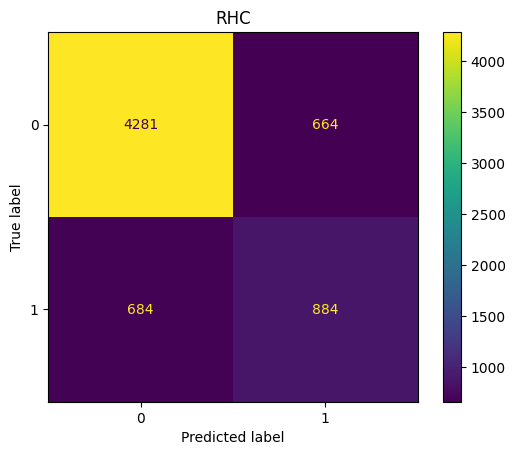

In [23]:
classes = [0, 1]
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.title("RHC")
plt.show()